# Baseline model for batch monitoring example

In [ ]:
import evidently
print(f"Evidently version: {evidently.__version__}")

# Let's see what's actually available in your installation
import evidently
print("\nAvailable modules in evidently:")
print([item for item in dir(evidently) if not item.startswith('_')])

# Let's also check what's in the top-level package
import pkgutil
import evidently
print("\nAvailable submodules:")
for importer, modname, ispkg in pkgutil.iter_modules(evidently.__path__):
    print(f"  {modname} (package: {ispkg})")
    
    

Evidently version: 0.7.8

Available modules in evidently:
['BinaryClassification', 'ColumnType', 'DataDefinition', 'Dataset', 'MulticlassClassification', 'Recsys', 'Regression', 'Report', 'Run', 'compare', 'core', 'errors', 'legacy', 'llm', 'metrics', 'nbextension', 'pipeline', 'presets', 'pydantic_utils', 'tests', 'version_info']

Available submodules:


In [33]:
# Let's see what's available in the presets module
import evidently.presets as presets
print("Available in evidently.presets:")
preset_items = [item for item in dir(presets) if not item.startswith('_')]
print(preset_items)

# Let's also check what's in metrics
import evidently.metrics as metrics
print("\nAvailable in evidently.metrics:")
metric_items = [item for item in dir(metrics) if not item.startswith('_')]
print(metric_items)


Available in evidently.presets:
['ClassificationDummyQuality', 'ClassificationPreset', 'ClassificationQuality', 'ClassificationQualityByLabel', 'DataDriftPreset', 'DataSummaryPreset', 'DatasetStats', 'RegressionDummyQuality', 'RegressionPreset', 'RegressionQuality', 'TextEvals', 'ValueStats', 'classification', 'dataset_stats', 'drift', 'regression']

Available in evidently.metrics:
['AbsMaxError', 'Accuracy', 'AlmostConstantColumnsCount', 'AlmostDuplicatedColumnsCount', 'CategoryCount', 'ColumnCount', 'ConstantColumnsCount', 'DatasetMissingValueCount', 'DriftedColumnsCount', 'DummyAccuracy', 'DummyF1Score', 'DummyFNR', 'DummyFPR', 'DummyLogLoss', 'DummyMAE', 'DummyMAPE', 'DummyPrecision', 'DummyRMSE', 'DummyRecall', 'DummyRocAuc', 'DummyTNR', 'DummyTPR', 'DuplicatedColumnsCount', 'DuplicatedRowCount', 'EmptyColumnsCount', 'EmptyRowsCount', 'F1ByLabel', 'F1Score', 'FBetaTopK', 'FNR', 'FPR', 'GroupBy', 'HitRate', 'InListValueCount', 'InRangeValueCount', 'LogLoss', 'MAE', 'MAP', 'MAPE', '

In [83]:
import requests
import datetime
import pandas as pd

from evidently import Dataset
from evidently import DataDefinition
from evidently import Report
from evidently.presets import DataDriftPreset, DataSummaryPreset
# Remove the old metrics imports for now unless you specifically need them
# from evidently.metrics import ValueDrift, DriftedColumnsCount, DatasetMissingValueCount

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

print("All imports successful!")

All imports successful!


In [84]:
files = [('green_tripdata_2022-02.parquet', './data'), ('green_tripdata_2022-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2022-01.parquet: 100%|██████████| 1254291/1254291 [00:14<00:00, 85516.66it/s, save to ./data/green_tripdata_2022-01.parquet] 


In [85]:
jan_data = pd.read_parquet('data/green_tripdata_2022-01.parquet')


In [86]:
jan_data.describe()


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,62495.000000,62495,62495,56200.000000,62495.000000,62495.000000,56200.000000,62495.000000,62495.000000,62495.00000,62495.000000,62495.000000,62495.000000,62495.000000,62495.000000,56200.000000,56200.000000,56200.000000
mean,1.849508,2022-01-16 14:18:36.026354,2022-01-16 14:37:37.189551,1.198719,97.615041,135.969902,1.258399,77.758632,13.914000,0.34756,0.426322,1.666540,0.208182,0.297312,17.490532,1.403594,1.040925,0.706628
min,1.000000,2009-01-01 00:34:01,2009-01-01 17:05:20,1.000000,1.000000,1.000000,0.000000,0.000000,-65.000000,-4.50000,-0.500000,-0.860000,-6.550000,-0.300000,-71.850000,1.000000,1.000000,0.000000
25%,2.000000,2022-01-08 23:41:50,2022-01-08 23:55:28.500000,1.000000,55.000000,74.000000,1.000000,1.080000,7.000000,0.00000,0.500000,0.000000,0.000000,0.300000,9.360000,1.000000,1.000000,0.000000
50%,2.000000,2022-01-16 15:59:42,2022-01-16 16:17:00,1.000000,75.000000,137.000000,1.000000,1.900000,10.500000,0.00000,0.500000,1.000000,0.000000,0.300000,13.860000,1.000000,1.000000,0.000000
75%,2.000000,2022-01-24 09:16:50,2022-01-24 09:37:28,1.000000,130.000000,215.000000,1.000000,3.500000,17.000000,0.50000,0.500000,2.610000,0.000000,0.300000,21.050000,2.000000,1.000000,2.750000
max,2.000000,2022-01-31 23:57:37,2022-02-01 21:01:54,5.000000,265.000000,265.000000,8.000000,224481.380000,604.500000,4.50000,0.500000,76.770000,44.750000,0.300000,605.300000,5.000000,2.000000,2.750000
std,0.357556,NaN,NaN,0.862313,62.987311,77.590956,0.877743,2909.354163,12.088819,0.65781,0.181381,2.484928,1.257659,0.037201,13.623416,0.516316,0.198119,1.201632


In [87]:
jan_data.shape


(62495, 20)

In [88]:
# create target
jan_data["duration_min"] = jan_data.lpep_dropoff_datetime - jan_data.lpep_pickup_datetime
jan_data.duration_min = jan_data.duration_min.apply(lambda td : float(td.total_seconds())/60)


In [89]:
# filter out outliers
jan_data = jan_data[(jan_data.duration_min >= 0) & (jan_data.duration_min <= 60)]
jan_data = jan_data[(jan_data.passenger_count > 0) & (jan_data.passenger_count <= 8)]


<Axes: >

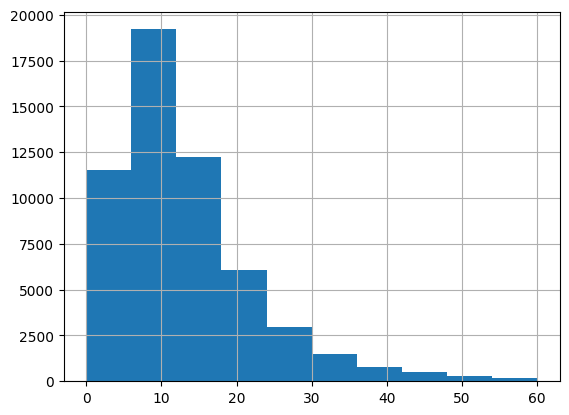

In [41]:
jan_data.duration_min.hist()


In [90]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]


In [91]:
jan_data.shape


(55211, 21)

In [92]:
train_data = jan_data[:30000]
val_data = jan_data[30000:]


In [93]:
model = LinearRegression()


In [94]:
model.fit(train_data[num_features + cat_features], train_data[target])


LinearRegression()

In [47]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds


In [48]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds


In [49]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))


3.804665373785064
4.14206407368845


In [50]:
with open('models/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)


In [51]:
val_data.to_parquet('data/reference.parquet')


In [95]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [114]:
# Try reinstalling evidently properly
# Run these commands in separate cells:

!pip uninstall evidently -y


In [115]:
!pip install evidently==0.7.8


  Using cached evidently-0.7.8-py3-none-any.whl.metadata (10 kB)
Using cached evidently-0.7.8-py3-none-any.whl (5.2 MB)


In [116]:
!pip install evidently[fsspec]

  Using cached fsspec-2025.5.1-py3-none-any.whl.metadata (11 kB)
Using cached fsspec-2025.5.1-py3-none-any.whl (199 kB)
   ---------------------------------------- 13.6/13.6 MB 35.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: botocore
    Found existing installation: botocore 1.38.18
    Uninstalling botocore-1.38.18:
      Successfully uninstalled botocore-1.38.18



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mage-ai 0.9.76 requires cryptography==42.0.4, but you have cryptography 45.0.4 which is incompatible.
mage-ai 0.9.76 requires Faker==4.14.0, but you have faker 37.4.0 which is incompatible.
mage-ai 0.9.76 requires httpx==0.25.0, but you have httpx 0.28.1 which is incompatible.
mage-ai 0.9.76 requires Jinja2==3.1.3, but you have jinja2 3.1.6 which is incompatible.
mage-ai 0.9.76 requires requests~=2.31.0, but you have requests 2.32.4 which is incompatible.
mage-ai 0.9.76 requires sqlalchemy<2.0.0,>=1.4.20, but you have sqlalchemy 2.0.41 which is incompatible.
mage-ai 0.9.76 requires typer[all]==0.9.0, but you have typer 0.16.0 which is incompatible.
mage-ai 0.9.76 requires typing_extensions==4.10.0, but you have typing-extensions 4.14.0 which is incompatible.
prefect 3.4.5 requires pydantic!=2.10.0,<3.0.0,>=2.9, bu

In [117]:
from evidently.metrics import ValueDrift, DriftedColumnsCount, DatasetMissingValueCount

report = Report(metrics=[
    ValueDrift(column='prediction'),       # Changed from column_name to column
    DriftedColumnsCount(),                 
    DatasetMissingValueCount()             
])

In [118]:
from evidently import Dataset, DataDefinition

# Update your DataDefinition to include the target column
schema = DataDefinition(
    numerical_columns=num_features + [target],  # Add target to numerical columns
    categorical_columns=cat_features,
)

# Create Dataset objects
train_dataset = Dataset.from_pandas(
    train_data[num_features + cat_features + [target]], 
    data_definition=schema
)

val_dataset = Dataset.from_pandas(
    val_data[num_features + cat_features + [target]], 
    data_definition=schema
)

# Run the report
report = Report(metrics=[
    ValueDrift(column='duration_min'),     # Monitor drift in your target
    DriftedColumnsCount(),                 
    DatasetMissingValueCount()             
])

# Run the report (this part worked)
my_eval = report.run(reference_data=train_dataset, current_data=val_dataset)

# Save to HTML file instead of displaying inline
my_eval.save_html("drift_report.html")
print("Report saved to drift_report.html")

Report saved to drift_report.html


In [120]:
# Try to display the report directly
try:
    display(report)
except Exception as e:
    print(f"Display failed: {e}")
    # Try just calling the report object
    report

In [ ]:
# Try to display the report directly in Jupyter
report


In [126]:
# Try different methods to get results
print("Type of my_eval:", type(my_eval))
print("Available methods:", [method for method in dir(my_eval) if not method.startswith('_')])

Type of my_eval: <class 'evidently.core.report.Snapshot'>
Available methods: ['context', 'dict', 'dump_dict', 'dumps', 'get_html_str', 'json', 'load', 'load_dict', 'load_model', 'loads', 'render_only_fingerprint', 'report', 'run', 'save_html', 'save_json', 'tests_results', 'to_snapshot_model']


In [127]:
# Option 1: Use dict() method
try:
    result = my_eval.dict()
    print("=== DRIFT REPORT RESULTS ===")
    print("Keys in result:", list(result.keys()))
    
    # Print organized results
    for key, value in result.items():
        print(f"\n{key}:")
        if isinstance(value, dict):
            for sub_key, sub_value in value.items():
                print(f"  {sub_key}: {sub_value}")
        else:
            print(f"  {value}")
            
except Exception as e:
    print(f"dict() failed: {e}")

=== DRIFT REPORT RESULTS ===
Keys in result: ['metrics', 'tests']

metrics:
  [{'id': 'd001a44f99cec47d98f701cbcd29f4ab', 'metric_id': 'ValueDrift(column=duration_min)', 'value': 0.09248288726721808}, {'id': '15e89f895b482f9b84ba7274ed18a106', 'metric_id': 'DriftedColumnsCount(drift_share=0.5)', 'value': {'count': 0.0, 'share': 0.0}}, {'id': '89b8d715e93a15e3acbc483410aff2f4', 'metric_id': 'DatasetMissingValueCount()', 'value': {'count': 0.0, 'share': 0.0}}]

tests:
  []


In [129]:
result

{'metrics': [{'id': 'd001a44f99cec47d98f701cbcd29f4ab',
   'metric_id': 'ValueDrift(column=duration_min)',
   'value': 0.09248288726721808},
  {'id': '15e89f895b482f9b84ba7274ed18a106',
   'metric_id': 'DriftedColumnsCount(drift_share=0.5)',
   'value': {'count': 0.0, 'share': 0.0}},
  {'id': '89b8d715e93a15e3acbc483410aff2f4',
   'metric_id': 'DatasetMissingValueCount()',
   'value': {'count': 0.0, 'share': 0.0}}],
 'tests': []}

In [131]:
# The drift score is directly in 'value', not nested in 'result'
drift_score = result['metrics'][0]['value']
print(f"Duration drift score: {drift_score}")

Duration drift score: 0.09248288726721808


In [132]:
# Correct way to access number of drifted columns
drifted_columns_count = result['metrics'][1]['value']['count']
print(f"Number of drifted columns: {drifted_columns_count}")

Number of drifted columns: 0.0


In [133]:
# Correct way to access share of missing values
missing_values_share = result['metrics'][2]['value']['share']
print(f"Share of missing values: {missing_values_share}")

Share of missing values: 0.0


# Evidently Dashboard


In [145]:
from evidently.presets import DataDriftPreset, DataSummaryPreset
from evidently.ui.workspace import Workspace
from evidently.legacy.ui.dashboards import DashboardPanelCounter, DashboardPanelPlot, CounterAgg, PanelValue, PlotType, ReportFilter

✅ Workspace available
❌ Dashboard components not available: No module named 'evidently.ui.dashboards'

=== USING WORKSPACE (if available) ===
✅ Workspace and project created successfully


In [146]:
# Create a simple WidgetSize class since the module isn't available
class WidgetSize:
    HALF = 1
    FULL = 2

# Create workspace and project
ws = Workspace("workspace")
project = ws.create_project("NYC Taxi Data Quality Project")
project.description = "My project description"
project.save()

print("Workspace and project created successfully")


Workspace and project created successfully


In [152]:
# Delete the old project and create a new one
ws.delete_project(project.id)

# Create a fresh project
project = ws.create_project("NYC Taxi Data Quality Project v2")
project.description = "My project description"
project.save()

print("New project created successfully")

New project created successfully


In [153]:
# Add only the plot panel first
project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Inference Count",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                field_path="current.number_of_rows",
                legend="count"
            ),
        ],
        plot_type=PlotType.BAR,
        size=WidgetSize.HALF,
    )
)

print("Plot panel added successfully")

Plot panel added successfully


In [157]:
# Add the missing values plot panel with metric_fingerprint
project.dashboard.add_panel(
    DashboardPanelPlot(
        filter=ReportFilter(metadata_values={}, tag_values=[]),
        title="Number of Missing Values",
        values=[
            PanelValue(
                metric_id="DatasetSummaryMetric",
                metric_fingerprint="DatasetSummaryMetric", 
                field_path="current.number_of_missing_values",
                legend="count"
            ),
        ],
        plot_type=PlotType.LINE,
        size=WidgetSize.HALF,
    )
)

print("Missing values panel added successfully")

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\Ultracell\anaconda3\envs\MLOPs\Lib\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Ultracell\AppData\Local\Temp\ipykernel_50584\385186703.py", line 2, in <module>
    project.dashboard.add_panel(
  File "c:\Users\Ultracell\anaconda3\envs\MLOPs\Lib\site-packages\evidently\ui\workspace.py", line 184, in add_panel
    _dashboard_model = self.model()
                       ^^^^^^^^^^^^
  File "c:\Users\Ultracell\anaconda3\envs\MLOPs\Lib\site-packages\evidently\ui\workspace.py", line 230, in model
    return self._workspace.get_dashboard(self.project_id)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ultracell\anaconda3\envs\MLOPs\Lib\site-packages\evidently\ui\workspace.py", line 429, in get_dashboard
    return self.state.read_dashboard(project_id)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ult

In [ ]:
# Save the project with just one panel
project.save()
print("Project saved successfully")

Project saved successfully


: 